<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [62]:
# Import packages
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from __future__ import division

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

# Initial Exploration of Data

In [63]:
# Load the data
house = pd.read_csv('./housing.csv')

# Print head of house dataframe
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


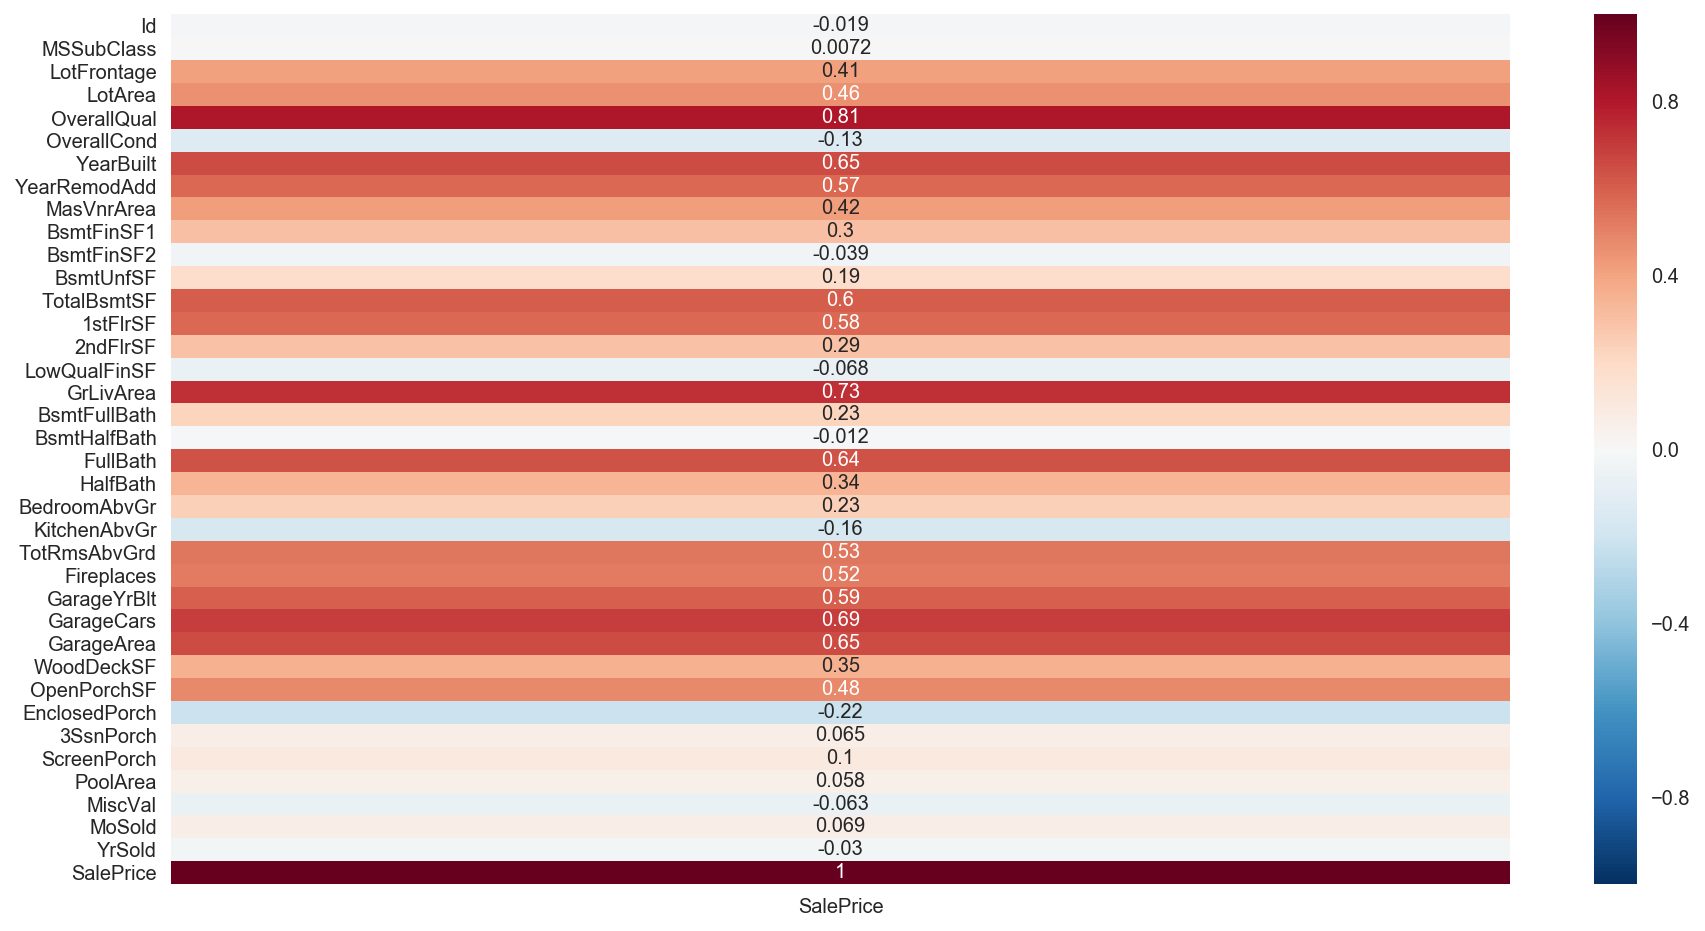

In [16]:
plt.figure(figsize=(15,8))

corr = house.corr(method='spearman')

sns.heatmap(corr.iloc[:,-1:], annot=True)

#sns.heatmap(house.corr(method='spearman'), annot=True)

## Relationships
Strong positive correlation:
* OverallQual
* YearBuilt
* YearRemodAdd
* TotalBsmtSF
* 1stFlrSF
* GrLivArea
* FullBath
* TotRmsAbvGrd
* Fireplaces
* GarageYrBlt
* GarageCars
* GarageArea

Positive correlation:
* LotFrontage
* LotArea
* MasVnrArea
* BsmtFinSF1
* WoodDeckSF
* OpenPorchSF

We will take note of these for when we start modelling later

In [17]:
# Print tail of dataframe
house.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [18]:
# Print column headers of house
house.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'Pav

# Data Cleaning:
The data will be cleaned by:
* Removing duplicates
* Checking for null values
* Conversion of compatible columns to non-object types if possible
        

In [65]:
# Initial check of shape before manipulation
house.shape

(1460, 81)

In [66]:
# Drop duplicates found within dataframe
house.drop_duplicates()

# Check shape of dataframe to determine if changes occurred
house.shape

(1460, 81)

# Datatypes
* Using house.info() and the text file describing the dataset, we are able to determine which columns are considered categorical, and which ones contain continous data.

In [8]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

## Continous Data
* MasVnrArea: Masonry veneer area in square feet
* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
* BsmtFinSF1: Type 1 finished square feet
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* LowQualFinSF: Low quality finished square feet (all floors)
* GrLivArea: Above grade (ground) living area square feet
* GarageYrBlt: Year garage was built
* GarageArea: Size of garage in square feet
* WoodDeckSF: Wood deck area in square feet
* OpenPorchSF: Open porch area in square feet
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* MiscVal: (Dollar)Value of miscellaneous feature
* YrSold: Year Sold (YYYY)


## Discrete (potentially)

* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade
* Bedroom: Bedrooms above grade (does NOT include basement bedrooms)
* Kitchen: Kitchens above grade
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* Fireplaces: Number of fireplaces
* GarageCars: Size of garage in car capacity
* MoSold: Month Sold (MM)


## Steps
* Attempt to convert all above Discrete variables into non-object types. Other columns tend to hold categorical data, sometimes in the form of code strings (eg. two letter notation for MSzoning) or 1-10 ranking metrics.
* Those considered optional qualities of a house (such as Pool or fireplace) null values will be replaced with 0


In [67]:
# Check for null values in each column
house.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageCond         81
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageQual         81
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
Utilities           0
YearRemodAdd        0
MSSubClass          0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearBuilt           0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

Upon closer inspection of the columns' null values, it is found that the null values are within columns that have reasonable reasons to be null. The important columns of MSZoning (used for filtering residential properties) and SalePrice (used as our target) contain no null values.

## Potential Dummy Variables
* MSSubClass: 16 dummies
* MSZoning: 8 Dummies
* Street: 4 Dummies
* Alley: 3 dummies
* LotShape: 4 dummies
* LandContour: 4 dummies
* Utilities: 4 dummies
* LotConfig: 4 dummies
* LandSlope: 3 dummies
* Neighborhood: 25 dummies
* Condition1: 9 dummies
* BldgType: 5 dummies
* HouseStyle: 8 dummies
* RoofStyle: 6 dummies
* RoofMatl: 8 dummies
* Exterior!st: 17 dummies
* MasVnrType: 5 dummies
* Foundation: 6 dummies
* BsmtExposure: 5 dummies
* Heating: 6 dummies
* CentralAir: Replace in column with binary
* Electrical: 5 dummies
* Functional: 8 dummmies
* GarageType: 7 dummies
* PavedDrive: 3 dummies
* MiscFeature: 6 dummies
* SaleType: 10 dummies
* SaleCondition: 6 dummies

## Conversion from categorical to numeric?
* ExterQual: Replace with 1-5?
* ExterCond: Replace 1-5?
* BsmtQual: Replace with values
* BsmtCond: Replace ith values 1-5
* BsmtFinType1: Replace with 7 levels
* HeatingQC: Replace with 5 levels
* KitchenQual: Replace with 1-5
* FireplaceQu: Replace with 0-5
* GarageFinish: 0-3
* GarageQual: 0-5
* GarageCond: 0-5
* PoolQC: 0-4
* Fence: 0-4

# Dummy Variable Creation and Concatenation

In [68]:
# Create dummy df of MSSubClass
Subclassdum = pd.get_dummies(house['MSSubClass'])

# Rename columns 
Subclassdum.columns = ['MSSub_20','MSSub_30','MSSub_40','MSSub_45','MSSub_50','MSSub_60','MSSub_70','MSSub_75',
                      'MSSub_80','MSSub_85','MSSub_90','MSSub_120','MSSub_160','MSSub_180','MSSub_190']

# Concatenate dummy variables into main df: house
house = pd.concat([house, Subclassdum], axis=1, join='outer')

In [71]:
# Create dummy df of MSZoning
Zoneclassdum = pd.get_dummies(house['MSZoning'])

# Rename columns
Zoneclassdum.columns = ['MSZon_Commercial','MSZon_Resi_FloatVillage','MSZon_Resi_HighDensity','MSZon_Resi_LowDensity',
                        'MSZon_Resi_MedDensity']

# Concatenate dummy variables into main df: house
house = pd.concat([house, Zoneclassdum], axis=1, join='outer')

In [73]:
# Create dummies
streetdum = pd.get_dummies(house['Street'])

# Rename columns
streetdum.columns = ['Street_Gravel', 'Street_Paved']

# Concatenate dummy variables into main df: house
house = pd.concat([house, streetdum], axis=1, join='outer')

In [75]:
# Create dummies
alleydum = pd.get_dummies(house['Alley'])

# Rename columns
alleydum.columns = ['Alley_Gravel', 'Alley_Paved']

# Concatenate dummy variables into main df: house
house = pd.concat([house, alleydum], axis=1, join='outer')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MSSub_190,MSZon_Commercial,MSZon_Resi_FloatVillage,MSZon_Resi_HighDensity,MSZon_Resi_LowDensity,MSZon_Resi_MedDensity,Street_Gravel,Street_Paved,Alley_Gravel,Alley_Paved
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,0,1,0,0,1,0,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,0,1,0,0,1,0,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,0,1,0,0,1,0,0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,0,1,0,0,1,0,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,0,1,0,0,1,0,0


In [77]:
# Create dummies
lotshapedum = pd.get_dummies(house['LotShape'])

# Rename columns
lotshapedum.columns = ['LotSha_SlightIrregular','LotSha_ModIrregular','LotSha_Irregular',
                       'LotSha_Regular']

# Concatenate dummy variables into main df: house
house = pd.concat([house, lotshapedum], axis=1, join='outer')

In [79]:
# Create dummies
contourdum = pd.get_dummies(house['LandContour'])

# Rename columns
contourdum.columns = ['LContour_Banked','LContour_Hillside','LContour_Depression','LContour_Flat']

# Concatenate dummy variables into main df: house
house = pd.concat([house, contourdum], axis=1, join='outer')

In [81]:
# Create dummies
hooddum = pd.get_dummies(house['Neighborhood'])

# Rename columns
for i in hooddum.columns:
    hooddum.rename(columns={i: 'Hood_'+str(i)}, inplace=True)

# Concatenate dummy variables into main df: house
house = pd.concat([house, hooddum], axis=1, join='outer')

In [83]:
# Create dummies
condi1dum = pd.get_dummies(house['Condition1'])

# Rename columns
for i in condi1dum.columns:
    condi1dum.rename(columns={i: 'Condi1_'+str(i)}, inplace=True)
    
# Concatenate dummy variables into main df: house
house = pd.concat([house, condi1dum], axis=1, join='outer')

In [85]:
# Create dummies
bldgtypedum = pd.get_dummies(house['BldgType'])

# Rename columns
bldgtypedum.columns = ['BldgType_1fam','BldgType_2famconv','BldgType_duplex','BldgType_twnhsIns','BldgType_twnhsEnd',]

# Concatenate dummy variables into main df: house
house = pd.concat([house, bldgtypedum], axis=1, join='outer')

In [87]:
# Create dummies
houseStyleDum = pd.get_dummies(house['HouseStyle'])

# Rename columns
for i in houseStyleDum.columns:
    houseStyleDum.rename(columns={i: 'HouStyle_'+str(i)}, inplace=True)

# Concatenate dummy variables into main df: house
house = pd.concat([house, houseStyleDum], axis=1, join='outer')

In [89]:
# Create dummies
roofStyleDum = pd.get_dummies(house['RoofStyle'])

# Rename columns
for i in roofStyleDum.columns:
    roofStyleDum.rename(columns={i: 'RoofStyle_'+str(i)}, inplace=True)

# Concatenate dummy variables into main df: house
house = pd.concat([house, roofStyleDum], axis=1, join='outer')

In [91]:
# Create dummies
roofMatlDum = pd.get_dummies(house['RoofMatl'])

# Rename columns
for i in roofMatlDum.columns:
    roofMatlDum.rename(columns={i: 'RoofMatl_'+str(i)}, inplace=True)

# Concatenate dummy variables into main df: house
house = pd.concat([house, roofMatlDum], axis=1, join='outer')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,1,0,0,0,0,0,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,1,0,0,0,0,0,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,1,0,0,0,0,0,0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,1,0,0,0,0,0,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,1,0,0,0,0,0,0


In [93]:
# Create dummies
ExteriorDum = pd.get_dummies(house['Exterior1st'])

# Rename columns
for i in ExteriorDum.columns:
    ExteriorDum.rename(columns={i: 'Exter1_'+str(i)}, inplace=True)
    
# Concatenate dummy variables into main df: house
house = pd.concat([house, ExteriorDum], axis=1, join='outer')

In [95]:
# Create dummies
MasVnrDum = pd.get_dummies(house['MasVnrType'])

# Rename columns
for i in MasVnrDum.columns:
    MasVnrDum.rename(columns={i: 'MasVnr_'+str(i)}, inplace=True)

# Concatenate dummy variables into main df: house
house = pd.concat([house, MasVnrDum], axis=1, join='outer')

In [97]:
# Create dummies
foundDum = pd.get_dummies(house['Foundation'])

# Rename columns
for i in foundDum.columns:
    foundDum.rename(columns={i: 'Fndtn_'+str(i)}, inplace=True)
    
# Concatenate dummy variables into main df: house
house = pd.concat([house, foundDum], axis=1, join='outer')

In [99]:
# Create dummies
utilDum = pd.get_dummies(house['Utilities'])

# Rename columns
utilDum.columns = ['Util_All', 'Util_NoSewa']

# Concatenate dummy variables into main df: house
house = pd.concat([house, utilDum], axis=1, join='outer')

In [101]:
# Create dummies
heatingDum = pd.get_dummies(house['Heating'])

# Rename columns
for i in heatingDum.columns:
    heatingDum.rename(columns={i: 'Heatg_'+str(i)}, inplace=True)
    
# Concatenate dummy variables into main df: house
house = pd.concat([house, heatingDum], axis=1, join='outer')

In [103]:
# Create dummies
electricDum = pd.get_dummies(house['Electrical'])

# Rename columns
for i in electricDum.columns:
    electricDum.rename(columns={i: 'Elec_'+str(i)}, inplace=True)

# Concatenate dummy variables into main df: house
house = pd.concat([house, electricDum], axis=1, join='outer')

In [105]:
# Create dummies
functionDum = pd.get_dummies(house['Functional'])

# Rename columns
for i in functionDum.columns:
    functionDum.rename(columns={i: 'Func_'+str(i)}, inplace=True)

# Concatenate dummy variables into main df: house
house = pd.concat([house, functionDum], axis=1, join='outer')

In [107]:
# Create dummies
garagetypeDum = pd.get_dummies(house['GarageType'])

# Rename columns
for i in garagetypeDum.columns:
    garagetypeDum.rename(columns={i: 'GarType_'+str(i)}, inplace=True)

# Concatenate dummy variables into main df: house
house = pd.concat([house, garagetypeDum], axis=1, join='outer')

In [109]:
# Create dummies
lotconDum = pd.get_dummies(house['LotConfig'])

# Rename columns
lotconDum.columns = ['LotCon_Corner','LotCon_CulDSac','LotCon_Front2','LotCon_Front3','LotCon_Inside',]

# Concatenate dummy variables into main df: house
house = pd.concat([house, lotconDum], axis=1, join='outer')

In [111]:
# Create dummies
pavedDriveDum = pd.get_dummies(house['PavedDrive'])

# Rename columns
pavedDriveDum.columns = ['Paved_DirtGrav', 'Paved_part', 'Paved_paved']

# Concatenate dummy variables into main df: house
house = pd.concat([house, pavedDriveDum], axis=1, join='outer')

In [113]:
# Create dummies
miscfeatDum = pd.get_dummies(house['MiscFeature'])

# Rename 1 column
miscfeatDum.rename(columns={'TenC': 'TenCrt'}, inplace=True)

# Rename all by looping and adding suffix
for i in miscfeatDum.columns:
    miscfeatDum.rename(columns={i: 'MiscFeat_'+str(i)}, inplace=True)

# Concatenate dummy variables into main df: house
house = pd.concat([house, miscfeatDum], axis=1, join='outer')

In [115]:
# Get dummies
saletypeDum = pd.get_dummies(house['SaleType'])

# Rename columns (more descriptive)
saletypeDum.columns = ['CrtOficDeedEst', 'CashWarrDeed', 'Con15dpReg', 'ConLwDp','ConLwInt',
                      'ConLwdpLwInt','New','Other', 'WarrDeed']
# Add prefix to columns
for i in saletypeDum.columns:
    saletypeDum.rename(columns={i: 'SaleType_'+str(i)}, inplace=True)

# Concatenate dummy variables into main df: house
house = pd.concat([house, saletypeDum], axis=1, join='outer')

In [117]:
# Get dummies
saleconDum = pd.get_dummies(house['SaleCondition'])

# Rename columns
for i in saleconDum.columns:
    saleconDum.rename(columns={i: 'SaleCond_'+str(i)}, inplace=True)

# Concatenate dummy variables into main df: house
house = pd.concat([house, saleconDum], axis=1, join='outer')

In [118]:
house.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType_ConLwdpLwInt,SaleType_New,SaleType_Other,SaleType_WarrDeed,SaleCond_Abnorml,SaleCond_AdjLand,SaleCond_Alloca,SaleCond_Family,SaleCond_Normal,SaleCond_Partial
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,1,0,0,0,0,1,0
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,1,0,0,0,0,1,0
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,1,0,0,0,0,1,0
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,1,0,0,0,0,1,0
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,1,0,0,0,0,1,0


In [131]:
house.isnull().sum().sort_values(ascending=False)
# house['MiscFeature'].fillna(value=0)
# house['Alley'].fillna(value=0)
# house.fillna(value=0)

SaleCond_Partial     0
SaleType             0
MSSub_90             0
MSSub_85             0
MSSub_80             0
MSSub_75             0
MSSub_70             0
MSSub_60             0
MSSub_50             0
MSSub_45             0
MSSub_40             0
MSSub_30             0
MSSub_20             0
SalePrice            0
SaleCondition        0
YrSold               0
MSSub_160            0
MoSold               0
MiscVal              0
MiscFeature          0
Fence                0
PoolQC               0
PoolArea             0
ScreenPorch          0
3SsnPorch            0
EnclosedPorch        0
OpenPorchSF          0
WoodDeckSF           0
PavedDrive           0
GarageCond           0
                    ..
HouStyle_SFoyer      0
HouStyle_SLvl        0
Exter1_VinylSd       0
Exter1_Stucco        0
Exter1_Stone         0
Exter1_Plywood       0
Exter1_MetalSd       0
Exter1_ImStucc       0
Exter1_HdBoard       0
Exter1_CemntBd       0
Exter1_CBlock        0
Exter1_BrkFace       0
Exter1_BrkC

# Converting level based variables to numeric

In [127]:
# Map individual columns below to produce numeric values from unicode-based levels
house['ExterQual'] = house['ExterQual'].map({'Gd': 4, 'TA': 3, 'Ex': 5, 'Fa': 2})
house['ExterCond'] = house['ExterCond'].map({'Gd': 4, 'TA': 3, 'Ex': 5, 'Fa': 2, 'Po': 1})
house['BsmtQual'] = house['BsmtQual'].map({'Gd': 4, 'TA': 3, 'Ex': 5, 'Fa': 2, 'Po': 1, np.nan: 0})
house['BsmtCond'] = house['BsmtCond'].map({'Gd': 4, 'TA': 3, 'Ex': 5, 'Fa': 2, 'Po': 1, np.nan: 0})
house['BsmtFinType1'] = house['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ':2, 'Unf': 1, np.nan: 0})
house['HeatingQC'] = house['HeatingQC'].map({'Gd': 4, 'TA': 3, 'Ex': 5, 'Fa': 2, 'Po': 1, np.nan: 0})
house['CentralAir'] = house['CentralAir'].map({'Y': 1, 'N': 0})
house['KitchenQual'] = house['KitchenQual'].map({'Gd': 4, 'TA': 3, 'Ex': 5, 'Fa': 2, 'Po': 1, np.nan: 0})
house['FireplaceQu'] = house['FireplaceQu'].map({'Gd': 4, 'TA': 3, 'Ex': 5, 'Fa': 2, 'Po': 1, np.nan: 0})
house['GarageFinish'] = house['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, np.nan: 0})
house['GarageQual'] = house['GarageQual'].map({'Gd': 4, 'TA': 3, 'Ex': 5, 'Fa': 2, 'Po': 1, np.nan: 0})
house['GarageCond'] = house['GarageCond'].map({'Gd': 4, 'TA': 3, 'Ex': 5, 'Fa': 2, 'Po': 1, np.nan: 0})
house['PoolQC'] = house['PoolQC'].map({'Gd': 4, 'TA': 3, 'Ex': 5, 'Fa': 2, 'Po': 1, np.nan: 0})
house['Fence'] = house['Fence'].map({'MnPrv': 3, 'GdWo': 2, 'GdPrv': 4, 'MnWw': 1, np.nan: 0})
house['LandSlope'] = house['LandSlope'].map({'Gtl': 1, 'Mod': 2, 'Sev': 3})
house['BsmtExposure'] = house['BsmtExposure'].map({'Gd': 3,'Av': 2, 'Mn': 1,'No': 0, np.nan: 0})

# Replace null values with 0
house['LotFrontage'] = house['LotFrontage'].fillna(value=0)
house['Alley'] = house['Alley'].fillna(value=0)
house['MasVnrArea'].fillna(value=0, inplace=True)

#Replace null garage yr built to that of structure built
house['GarageYrBlt'].fillna(value=house['YearBuilt'], inplace=True)

# Replace all remaining nulls with 0
house = house.fillna(value=0)

# The house Dataframe will be renamed and further split into the required datasets

In [274]:
# Make a copy of house and assign to df
df = house.copy()

# Split test and train data by years: pre-2010, 2010
test = df[df['YrSold']==2010]
train = df[df['YrSold']<2010]

# Assign to traindf and testdf a filtered version of test and train data
# of only residential properties
traindf = train[(train['MSZon_Resi_FloatVillage']==1) | (train['MSZon_Resi_HighDensity']==1) | (train['MSZon_Resi_LowDensity']==1) | (train['MSZon_Resi_MedDensity']==1)]
testdf = test[(test['MSZon_Resi_FloatVillage']==1) | (test['MSZon_Resi_HighDensity']==1) | (test['MSZon_Resi_LowDensity']==1) | (test['MSZon_Resi_MedDensity']==1)]

## Residential Properties
The dataset contains a number of categories of properties within the MSZoning variable. Residential properties start with an R, with options of RH, RL, RP, RM. We will separate those properties considered residential and place them in a separate dataframe

In [141]:
print(traindf.shape)
print(testdf.shape)

(1278, 252)
(172, 252)


# Determination of Predictors
## Fixed characteristics
The characteristics of a house determined to be fixed will be run through a correlation matrix to determine predictors.


### Converted to Dummy Variables
* MSSubclass
* MSZoning

* LotShape
* LandContour
* Utilities
* LotConfig
* LandSlope
* Neighborhood
* Condition1
* BldgType
* HouseStyle
* MasVnrType
* Foundation
* GarageType



### Ordinary Variables
* LotArea
* LotFrontage
* YearBuilt
* MasVnrArea
* BsmtExposure
* TotalBsmtSF
* 1stFlrSF
* 2ndFlrSF
* GrLivArea
* BsmtFullBath
* BsmtHalfBath
* Bedroom
* Kitchen
* Fireplaces
* GarageYrBlt
* GarageCars
* GarageArea
* WoodDeckSF
* OpenPorchSF
* EnclosedPorch
* 3SsnPorch
* ScreenPorch
* PoolArea

We will begin by training a model with all variables, and see how this compares to a model using our heatmap variables.

In [356]:
# Initialize training variables from heatmap analysis
heatX_train = train.loc[:, ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF',
                            '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 
                            'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
                            'WoodDeckSF','OpenPorchSF', 'BsmtFinSF1', 'MasVnrArea',
                            'LotFrontage', 'LotArea']]

optiX_train = train.loc[:, ['OverallQual', 'YearBuilt', 'YearRemodAdd', '1stFlrSF',
                          'GrLivArea','GarageCars', 'BsmtFinSF1', 'MasVnrArea', 
                          'LotArea']]
# Initialize y_train
y_train = train['SalePrice']

In [357]:
# Initialize test variables from heatmap analysis
heatX_test = test.loc[:, ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF',
                            '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 
                            'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
                            'WoodDeckSF','OpenPorchSF', 'BsmtFinSF1', 'MasVnrArea',
                            'LotFrontage', 'LotArea']]

optiX_test = test.loc[:, ['OverallQual', 'YearBuilt', 'YearRemodAdd', '1stFlrSF',
                          'GrLivArea','GarageCars', 'BsmtFinSF1', 'MasVnrArea', 
                          'LotArea']]

# Initialize y_test
y_test = test['SalePrice']

## Note:
In the next cell, run only one of the zscores (optimized or normal version)

In [358]:
from scipy.stats import zscore

# Standardize our train and test X 
standFixed = heatX_train.apply(zscore)
standFixed_test = heatX_test.apply(zscore)

# Standardize our optimized train and test X 
# standFixed = optiX_train.apply(zscore)
# standFixed_test = optiX_test.apply(zscore)

In [359]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Instantiate our regression models
model1 = LinearRegression()
model2 = LassoCV()
model3 = RidgeCV()
model4 = ElasticNetCV()

# Fit our models to our training data
model1.fit(standFixed, y_train)
model2.fit(standFixed, y_train)
model3.fit(standFixed, y_train)
model4.fit(standFixed, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [360]:
# Heatmap Model Score
from sklearn.metrics import mean_squared_error

print('Linear Reg: {}\nRMSE: {}\n'.format(model1.score(standFixed_test, y_test), 
                                        np.sqrt(mean_squared_error(y_test, model1.predict(standFixed_test)))))
print('Lasso: {}\nRMSE: {}\n'.format(model2.score(standFixed_test, y_test), 
                                        np.sqrt(mean_squared_error(y_test, model2.predict(standFixed_test)))))
print('Ridge: {}\nRMSE: {}\n'.format(model3.score(standFixed_test, y_test), 
                                        np.sqrt(mean_squared_error(y_test, model3.predict(standFixed_test)))))
print('ElasticNet: {}\nRMSE: {}\n'.format(model4.score(standFixed_test, y_test), 
                                        np.sqrt(mean_squared_error(y_test, model4.predict(standFixed_test)))))

Linear Reg: 0.828721397027
RMSE: 33200.1552446

Lasso: 0.821460194245
RMSE: 33896.5960187

Ridge: 0.829451924917
RMSE: 33129.2778683

ElasticNet: 0.136014389754
RMSE: 74566.1659625



In [329]:
# Optimized Model Score
from sklearn.metrics import mean_squared_error

print('Linear Reg: {}\nRMSE: {}\n'.format(model1.score(standFixed_test, y_test), 
                                        np.sqrt(mean_squared_error(y_test, model1.predict(standFixed_test)))))
print('Lasso: {}\nRMSE: {}\n'.format(model2.score(standFixed_test, y_test), 
                                        np.sqrt(mean_squared_error(y_test, model2.predict(standFixed_test)))))
print('Ridge: {}\nRMSE: {}\n'.format(model3.score(standFixed_test, y_test), 
                                        np.sqrt(mean_squared_error(y_test, model3.predict(standFixed_test)))))
print('ElasticNet: {}\nRMSE: {}\n'.format(model4.score(standFixed_test, y_test), 
                                        np.sqrt(mean_squared_error(y_test, model4.predict(standFixed_test)))))

Linear Reg: 0.825409853077
RMSE: 33519.5688409

Lasso: 0.825192985724
RMSE: 33540.3805656

Ridge: 0.825516078208
RMSE: 33509.3702059

ElasticNet: 0.0842423827444
RMSE: 76767.7528999



## Recursive Feature Elimination
We will try to use RFE to attempt to improve our model through feature selection.

When testing with the reduced features, the models did not improve in accuracy. As a result, we will attempt to improve our heatmap feature model using gridsearch below

In [315]:
from sklearn.feature_selection import RFE

# Fit RFE to current model
rfe = RFE(model3)
rfe = rfe.fit(standFixed, y_train)

# Print results of RFE
print(rfe.support_)
print(rfe.ranking_)
standFixed.columns[rfe.support_].values

[ True  True  True False  True  True False False False False  True False
 False False  True  True False  True]
[ 1  1  1  4  1  1 10  7  2  6  1  5  3  9  1  1  8  1]


array(['OverallQual', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', 'GrLivArea',
       'GarageCars', 'BsmtFinSF1', 'MasVnrArea', 'LotArea'], dtype=object)

# Use of GridSearch to improve parameters of model
* Results of GridSearch.best_params_ used above

In [313]:
from sklearn.model_selection import GridSearchCV

params = {
    # params for Ridge
    'cv': [None, 2, 3, 4, 5, 6]
    
}

search = GridSearchCV(model3, params, n_jobs=3)

In [314]:
search.fit(standFixed, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'cv': [None, 2, 3, 4, 5, 6]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [308]:
# Print results of Gridsearch for use
print(search.best_params_)
print(search.best_score_)

{'cv': None}
0.761546985071


## Results
Using gridsearch, we were recommended to keep our parameters as is. 

As a result, we will proceed with our original heatmap model using Ridge Cross Validated Regression. With this, we were able to achieve the scores below (82.94%)

In [361]:
# Import score packages
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Print r2 score and RMSE
print('Ridge: {}\nRMSE: {}\n'.format(model3.score(standFixed_test, y_test), 
                                        np.sqrt(mean_squared_error(y_test, model3.predict(standFixed_test)))))


# Calculate cross val score and mean
scores = cross_val_score(model3,standFixed_test,y=y_test)
print('All scores: {}\n Mean:{}'.format(scores, scores.mean()))

Ridge: 0.829451924917
RMSE: 33129.2778683

All scores: [ 0.79354938  0.81339641  0.85778876]
 Mean:0.821578185466


Using the above parameters for our gradient boosting regressor, we were able to improve our model. It now performs with a 88.68% r2 score.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

## Renovate-able characteristics
* OverallQual
* OverallCond
* ExterQual
* ExterCond
* BsmtQual
* BsmtCond
* BsmtFinType1
* Heating
* HeatingQC
* CentralAir
* Electrical : Dummy Variables
* KitchenQual
* Functional :Dummy
* FireplaceQu
* GarageFinish
* GarageQual
* GarageCond
* PavedDrive : Dummy
* PoolQC
* Fence
* TotRmsAbvGrd
* FullBath
* HalfBath
* RoofStyle
* RoofMatl
* Exterior1st

## Residuals
We will begin by calculating our residuals for both our training and testing set. 

We will generate the predicted values for our target for both sets and find the difference with the actual values.

We will then use the renovatable characteristics of a house to build a model to predict the residuals.

In [363]:
# Generate predicted value based on model
y_pred = model3.predict(standFixed_test)

# Generate predicted value of train set
y_prev = model3.predict(standFixed)

# Root mean squared error
np.sqrt(mean_squared_error(y_test, y_pred))

33129.277868251767

# Calculation of y_hat (residuals)

In [364]:
test.shape

(175, 253)

In [365]:
y_hat = y_test-y_pred
oldy_hat = y_train-y_prev

In [366]:
print(y_hat.shape)
print(oldy_hat.shape)

(175,)
(1285,)


Now we will assign the residuals to their relative tables as a new column

In [367]:
train['Residuals'] = oldy_hat
test['Residuals'] = y_hat

/Users/d/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/d/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [368]:
residuals = pd.DataFrame(y_hat)
residuals.rename(columns={'SalePrice': 'Residuals'}, inplace=True)

In [369]:
residuals.shape

(175, 1)

## Residual Plot

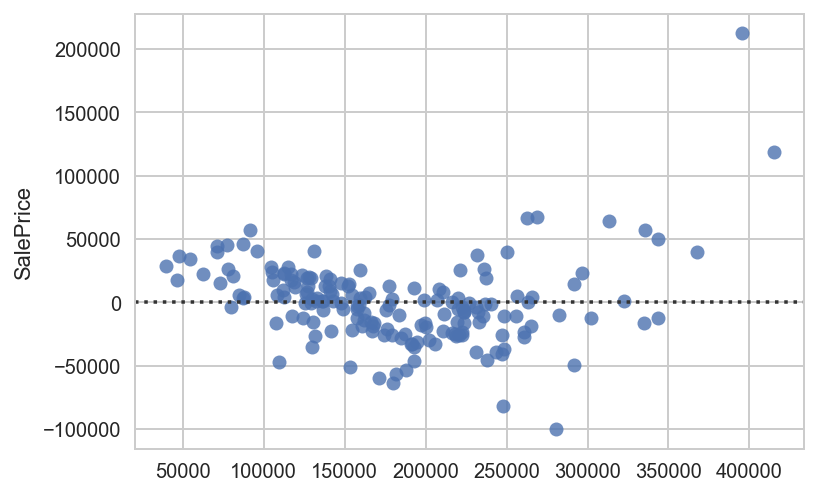

In [370]:
sns.residplot(x=y_pred, y=y_test, data=residuals)

# Declare train and test variables

In [417]:
# Assign renovatable characteristics to renoX_train and renoX_test
renoX_train = train.loc[:,['FireplaceQu','GarageFinish','GarageQual', 'GarageCond', 'PoolQC',
                         'ExterQual', 'ExterCond','BsmtQual', 'BsmtCond','BsmtFinType1','Heatg_Floor', 'Heatg_GasA', 
                         'Heatg_GasW', 'Heatg_Grav','Heatg_OthW', 'Heatg_Wall','HeatingQC','CentralAir', 'Elec_FuseA',
                         'Elec_FuseF', 'Elec_FuseP', 'Elec_Mix','Elec_SBrkr','KitchenQual', 'Func_Maj1', 'Func_Maj2', 
                         'Func_Min1', 'Func_Min2','Func_Mod', 'Func_Sev', 'Func_Typ','Paved_DirtGrav','Paved_part', 
                         'Paved_paved', 'Fence', 'TotRmsAbvGrd','FullBath', 'HalfBath','RoofStyle_Flat', 
                         'RoofStyle_Gable','RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard','RoofStyle_Shed',
                         'RoofMatl_ClyTile', 'RoofMatl_CompShg','RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
                         'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl','Exter1_AsbShng', 'Exter1_AsphShn',
                         'Exter1_BrkComm','Exter1_BrkFace', 'Exter1_CBlock','Exter1_CemntBd','Exter1_HdBoard', 
                         'Exter1_ImStucc', 'Exter1_MetalSd','Exter1_Plywood', 'Exter1_Stone', 'Exter1_Stucco', 
                         'Exter1_VinylSd','Exter1_Wd Sdng', 'Exter1_WdShing']]

renoX_test = test.loc[:,['FireplaceQu','GarageFinish','GarageQual', 'GarageCond', 'PoolQC',
                         'ExterQual', 'ExterCond','BsmtQual', 'BsmtCond','BsmtFinType1','Heatg_Floor', 'Heatg_GasA', 
                         'Heatg_GasW', 'Heatg_Grav','Heatg_OthW', 'Heatg_Wall','HeatingQC','CentralAir', 'Elec_FuseA',
                         'Elec_FuseF', 'Elec_FuseP', 'Elec_Mix','Elec_SBrkr','KitchenQual', 'Func_Maj1', 'Func_Maj2', 
                         'Func_Min1', 'Func_Min2','Func_Mod', 'Func_Sev', 'Func_Typ','Paved_DirtGrav','Paved_part', 
                         'Paved_paved', 'Fence', 'TotRmsAbvGrd','FullBath', 'HalfBath','RoofStyle_Flat', 
                         'RoofStyle_Gable','RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard','RoofStyle_Shed',
                         'RoofMatl_ClyTile', 'RoofMatl_CompShg','RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
                         'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl','Exter1_AsbShng', 'Exter1_AsphShn',
                         'Exter1_BrkComm','Exter1_BrkFace', 'Exter1_CBlock','Exter1_CemntBd','Exter1_HdBoard', 
                         'Exter1_ImStucc', 'Exter1_MetalSd','Exter1_Plywood', 'Exter1_Stone', 'Exter1_Stucco', 
                         'Exter1_VinylSd','Exter1_Wd Sdng', 'Exter1_WdShing']]

renoY_train = train['Residuals'].reset_index(drop=True)

renoY_test = test['Residuals'].reset_index(drop=True)

In [418]:
from scipy.stats import zscore

# Standardize our train and test X (we will also fill na as there was an issue with column
# 'Exter1_AsphShn')
renoX_train = renoX_train.apply(zscore).fillna(0)
renoX_test = renoX_test.apply(zscore).fillna(0)

In [398]:
# renoX_train, renoY_train
# renoX_test, renoY_test
print(renoY_train.shape)
print(renoX_train.shape)
print(renoY_test.shape)
print(renoX_test.shape)
print(standFixed.shape)
print(standFixed_test.shape)

(1285,)
(1285, 69)
(175,)
(175, 69)
(1285, 69)
(175, 69)


In [419]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Instantiate our regression models
model1 = LinearRegression()
model2 = LassoCV()
model3 = RidgeCV()
model4 = ElasticNetCV()

# Fit our models to our training data
model1.fit(renoX_train, renoY_train)
model2.fit(renoX_train, renoY_train)
model3.fit(renoX_train, renoY_train)
model4.fit(renoX_train, renoY_train)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [420]:
# Heatmap Model Score
from sklearn.metrics import mean_squared_error

print('Linear Reg: {}\nRMSE: {}\n'.format(model1.score(renoX_test, renoY_test), 
                                        np.sqrt(mean_squared_error(renoY_test, model1.predict(renoX_test)))))
print('Lasso: {}\nRMSE: {}\n'.format(model2.score(renoX_test, renoY_test), 
                                        np.sqrt(mean_squared_error(renoY_test, model2.predict(renoX_test)))))
print('Ridge: {}\nRMSE: {}\n'.format(model3.score(renoX_test, renoY_test), 
                                        np.sqrt(mean_squared_error(renoY_test, model3.predict(renoX_test)))))
print('ElasticNet: {}\nRMSE: {}\n'.format(model4.score(renoX_test, renoY_test), 
                                        np.sqrt(mean_squared_error(renoY_test, model4.predict(renoX_test)))))

Linear Reg: -8.55140009019e+19
RMSE: 3.04108797582e+14

Lasso: 0.0907723045754
RMSE: 31357.8803776

Ridge: 0.0932949963828
RMSE: 31314.3482593

ElasticNet: 0.00511393739352
RMSE: 32801.7522793



# Model Built to Account for Residuals
### Goal was to build a model based on renovatable features to predict whether residuals (errors) of previous model can be accounted for

* The best performing Model's score (above) is 9.07%. This is a reasonable score, meaning 9.07% of the residuals can be explained.
* This could potentially indicate that renovatable features only account for a maximum of 9.07% of changes in price.

* This indicates that the rest of the residuals may be irreducible. 

# Determining Dollar Value
* We only have access to the dollar value of misc features
* They are grouped below and presented with the mean of their values

In [141]:
df.groupby('MiscFeature')['MiscVal'].count()

MiscFeature
Gar2     2
Othr     2
Shed    49
TenC     1
Name: MiscVal, dtype: int64

In [140]:
df.groupby('MiscFeature')['MiscVal'].mean()

MiscFeature
Gar2    11900.000000
Othr     1750.000000
Shed      697.836735
TenC     2000.000000
Name: MiscVal, dtype: float64

In [147]:
df[['MiscFeature','MiscVal']][df['MiscFeature']=='Othr']

,MiscFeature,MiscVal
705,Othr,3500
873,Othr,0


# Miscellaneous Value
* Garage 2 is seen as the most valuable, with a value of \$11,900
* Tennis court is valued at approx. \$2000 (Only one case)
* Shed is approximately valued at \$698.00
* Others have 2 values, with one at \$3500 and the other at \$0

In [421]:
featcoefs = pd.DataFrame({'Features': renoX_train.columns.values, 'Coefs': model3.coef_})

In [425]:
featcoefs = featcoefs[['Features', 'Coefs']]
featcoefs.sort_values('Coefs', ascending=False)

,Features,Coefs
51,RoofMatl_WdShngl,5206.688935
4,PoolQC,4460.499387
7,BsmtQual,4195.001478
55,Exter1_BrkFace,3378.397021
5,ExterQual,3024.427026
23,KitchenQual,2942.431668
9,BsmtFinType1,2159.705263
38,RoofStyle_Flat,1898.323405
52,Exter1_AsbShng,1809.661333
35,TotRmsAbvGrd,1784.852815


# How to use Model

1. When purchasing a house, first check to see if any renovatable features are available.
2. Compare these features to the Features/Coefs table above to see rank of impact on SalePrice according to the model
3. Items higher on the list will generally provide a higher return on investment, whereas lower ones provide lower returns for the renovated feature
4. If the renovated item is a second garage, a tennis court or a shed, observe the value found above, and ensure not to go over the value as it's likely that you will not receive a greater return on investment
5. As an extremely general rule of thumb, limit expenditure on renovations by item to $3500, as for renovations categorised as 'other' (vague), seem to be valued as such

# Model Evaluation
Overall, the model of fixed characteristics explains 82.94% of the results, and the renovated characteristic model explains 9% of the residuals of the first model.  This is a fairly accurate model, explaining approximately 85% of saleprice using both fixed and renovatable features.


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: